In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skeleton import skeleton
import src.utils as utils
G, color_edge = skeleton()

In [76]:
def pts3d_to_angle(pts3d,G):
    '''compute joint angles from DeepFly3D'''
    
    n = int(len(G.nodes))
    j_angles = np.zeros((pts3d.shape[0], n), dtype=np.float32)
    err_j_angles = np.zeros((pts3d.shape[0], n), dtype=np.float32)
    
    for j in range(0, n): #joint
        if G.degree(j) == 1:
            nb = [n for n in G.neighbors(j)]
            if nb[0]>j:
                x0 = np.matlib.repmat(np.array([0,0,1]),pts3d.shape[0], 1)
                j_angles[:, j], err_j_angles[:, j] = cos_rule(pts3d[:, nb[0], :], pts3d[:, j, :], x0)
        
        if G.degree(j) == 2:    
            nb = [n for n in G.neighbors(j)]
            j_angles[:, j], err_j_angles[:, j] = cos_rule(pts3d[:, nb[0], :], pts3d[:, j, :], pts3d[:, nb[1], :])
            
    j_angles[np.logical_or(np.isnan(j_angles), np.isinf(j_angles))] = 0

    return j_angles, err_j_angles


def cos_rule(a, b, c):
    '''cos-rule between angle spanned by 3 points'''
    
    ba = a - b
    bc = c - b
    
    dotbabc = np.einsum("ij,ij->i", ba, bc)
    normba = np.linalg.norm(ba, axis=1)
    normbc = np.linalg.norm(bc, axis=1)
    
    varba = np.std(normba)
    varbc = np.std(normbc)
    
    cos_angle = dotbabc / (normba * normbc)
    angle = np.arccos(cos_angle)
    
    #uncertainty = x.y/|x||y| sqrt((d|x|/|x|)^2 + (d|y|/|y|)^2)
    angle_err = angle * np.sqrt( (varba/normba)**2+(varbc/normbc)**2 )
    
    return angle, angle_err


def plot_epoch(tint, j_angles, err_j_angles, joints, title, ylim, ax):
    ax.set_title(title)
    for j in joints:
        ax.plot(time, j_angles[:,j])
        #ax.fill_between(time, j_angles[:,j] - err_j_angles[:,j] , j_angles[:,j] + err_j_angles[:,j], alpha=0.3)
        #ax.fill_between(time, j_angles[:,j] - err_j_angles[:,j] , j_angles[:,j] + err_j_angles[:,j], alpha=0.3)
        
    ax.set_xlim([tint[0], tint[1]]) 
    ax.set_ylim(ylim)

In [77]:
data_dir = '/data/LiftFly3D/optobot/102906_s1a5_p6-0'
template_dir = '/data/LiftFly3D/optobot/network/'
        
#load predictions
data = torch.load(data_dir + '/test_results.pth.tar')

#output
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d']
out_mean = torch.load(data_dir + '/stat_3d.pth.tar')['mean']
out_std = torch.load(data_dir + '/stat_3d.pth.tar')['std']
out = utils.unNormalizeData(data['output'], out_mean[targets_1d], out_std[targets_1d])

#inputs
targets_2d = torch.load(template_dir + '/stat_2d.pth.tar')['targets_2d']    
inp_mean = torch.load(template_dir + 'stat_2d.pth.tar')['mean']
inp_std = torch.load(template_dir + 'stat_2d.pth.tar')['std']
inp = utils.unNormalizeData(data['input'], inp_mean[targets_2d], inp_std[targets_2d])

targets_1d = torch.load(template_dir + '/stat_3d.pth.tar')['targets_1d'] 
targets_2d = torch.load(template_dir + '/stat_2d.pth.tar')['targets_2d'] 
out = utils.expand(out,targets_1d,len(out_mean))
inp = utils.expand(inp,targets_2d,len(inp_mean))

poses = np.stack((inp[:,::2],inp[:,1::2],out), axis=2)

In [78]:
poses.shape

(799, 30, 3)

In [79]:
j_angles, err_j_angles = pts3d_to_angle(poses,G)
scale = 2.5/400
j_angles = np.degrees(j_angles)
j_angles -= np.mean(j_angles,axis=0)
err_j_angles = np.degrees(err_j_angles)

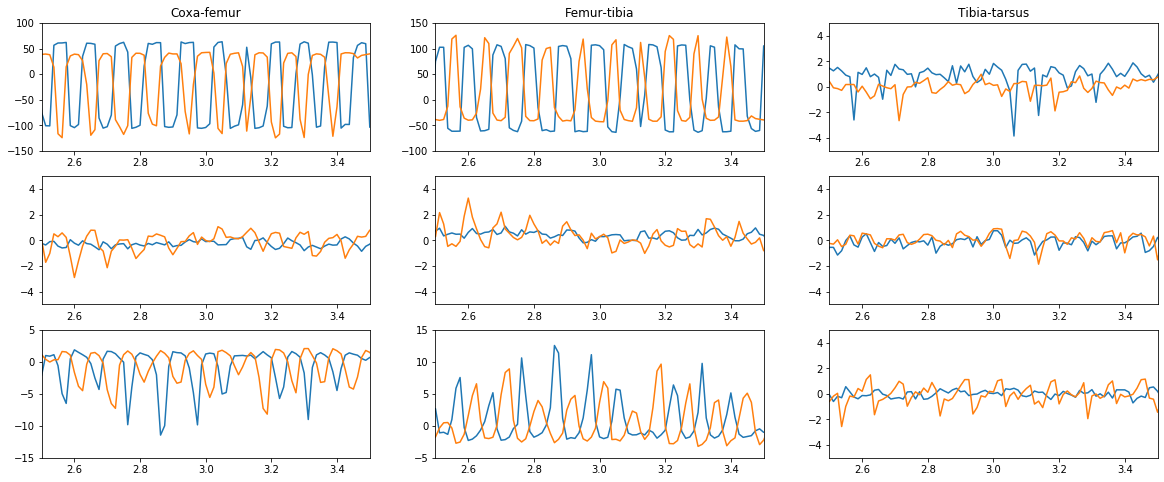

In [80]:
freq = 1/80
f, axs = plt.subplots(3, 3, figsize=(20,8))
time = np.arange(poses.shape[0])*freq 

tint = [2.5,3.5]
plot_epoch(tint, j_angles, err_j_angles, [0], '', [-150,100], axs[0,0])
plot_epoch(tint, j_angles, err_j_angles, [2], '', [-100,150], axs[0,1])
plot_epoch(tint, j_angles, err_j_angles, [3], '', [-5, 5], axs[0,2])
plot_epoch(tint, j_angles, err_j_angles, [15], 'Coxa-femur', [-150,100], axs[0,0])
plot_epoch(tint, j_angles, err_j_angles, [17], 'Femur-tibia', [-100,150], axs[0,1])
plot_epoch(tint, j_angles, err_j_angles, [18], 'Tibia-tarsus', [-5, 5], axs[0,2])

plot_epoch(tint, j_angles, err_j_angles, [5], '', [-5, 5], axs[1,0])
plot_epoch(tint, j_angles, err_j_angles, [7], '', [-5, 5], axs[1,1])
plot_epoch(tint, j_angles, err_j_angles, [8], '', [-5, 5], axs[1,2])
plot_epoch(tint, j_angles, err_j_angles, [20], '', [-5, 5], axs[1,0])
plot_epoch(tint, j_angles, err_j_angles, [22], '', [-5, 5], axs[1,1])
plot_epoch(tint, j_angles, err_j_angles, [23], '', [-5, 5], axs[1,2])

plot_epoch(tint, j_angles, err_j_angles, [10], '', [-15, 5], axs[2,0])
plot_epoch(tint, j_angles, err_j_angles, [12], '', [-5, 15], axs[2,1])
plot_epoch(tint, j_angles, err_j_angles, [13], '', [-5, 5], axs[2,2])
plot_epoch(tint, j_angles, err_j_angles, [25], '', [-15, 5], axs[2,0])
plot_epoch(tint, j_angles, err_j_angles, [27], '', [-5, 15], axs[2,1])
plot_epoch(tint, j_angles, err_j_angles, [28], '', [-5, 5], axs[2,2])
#plt.savefig('joint_angles.svg')

In [ ]:
tint = [0,60]


fig = plt.figure(figsize=([8,3])) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
#ax3 = fig.add_subplot(1, 2, 3)
#ax4 = fig.add_subplot(1, 2, 4)
#ax3 = fig.add_subplot(2, 2, 3, projection='3d') 

times = np.arange(tint[0],tint[1])
for i in [4,9,14,19,24,29]:
    ax1.plot(poses[times,i,0],poses[times,i,1],'o') 
       
for i in [4,9,14]: #plot projected tarsus coordinates
    ax2.plot(poses[times,i,0],-poses[times,i,2])
    
    #ax3.plot3D(data[:,i,0], data[:,i,1], data[:,i,2],'ro')
    
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')

#ax3.set_xlabel('dim 1')
#ax3.set_ylabel('dim 2')
#ax3.set_zlabel('dim 3')
plt.show()